# IMD Radar Data - Radarx
- Author: Hamid

Run these commands if you don't have radarx installed yet.
- First create conda/micromamba environment and activate it

```sh
micromamba create -n radar-env
```
2. Activate the environment
```sh
micromamba activate radar-env
```
3. Install the necessary packages
```sh
micromamba install python=3.12 nbclassic radarx arm_pyart -c conda-forge
```
4. Install Fast-Barnes package for faster gridding
```sh
python -m pip install git+https://github.com/MeteoSwiss/fast-barnes-py.git
```
4. Launch Jupyter Notebook (Classic Version)

```sh
jupyter-nbclassic
```

In [1]:
import os
import glob
import radarx as rx
import xradar as xd
import xarray as xr
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
files = glob.glob("PDP200519IMD-C/*")

In [3]:
dtree = rx.io.read_volume(files)

INFO:radarx.io.imd:Successfully grouped files into 25 sweep groups.


In [4]:
dtree.groups

('/',
 '/volume_0',
 '/volume_1',
 '/volume_2',
 '/volume_3',
 '/volume_4',
 '/volume_5',
 '/volume_6',
 '/volume_7',
 '/volume_8',
 '/volume_9',
 '/volume_10',
 '/volume_11',
 '/volume_12',
 '/volume_13',
 '/volume_14',
 '/volume_15',
 '/volume_16',
 '/volume_17',
 '/volume_18',
 '/volume_19',
 '/volume_20',
 '/volume_21',
 '/volume_22',
 '/volume_23',
 '/volume_24')

In [5]:
# We can save all these cfradial1 files by iterating over the dtree object

outdir = "IMD_OUT"
os.makedirs(outdir, exist_ok=True)
for key in dtree.children:
    ds = dtree[key].ds
    time_str = ds.time.min().dt.strftime("%Y%m%d_%H%M%S").item()
    ds.to_netcdf(os.path.join(outdir, f"PDP_{time_str}_cfrad1.nc"))

In [6]:
ls IMD_OUT

PDP_20200519_004025_cfrad1.nc  PDP_20200519_105026_cfrad1.nc
PDP_20200519_014025_cfrad1.nc  PDP_20200519_125136_cfrad1.nc
PDP_20200519_015025_cfrad1.nc  PDP_20200519_130026_cfrad1.nc
PDP_20200519_020026_cfrad1.nc  PDP_20200519_165026_cfrad1.nc
PDP_20200519_021025_cfrad1.nc  PDP_20200519_173026_cfrad1.nc
PDP_20200519_025025_cfrad1.nc  PDP_20200519_184026_cfrad1.nc
PDP_20200519_032025_cfrad1.nc  PDP_20200519_192026_cfrad1.nc
PDP_20200519_035025_cfrad1.nc  PDP_20200519_200026_cfrad1.nc
PDP_20200519_043026_cfrad1.nc  PDP_20200519_202025_cfrad1.nc
PDP_20200519_060025_cfrad1.nc  PDP_20200519_221026_cfrad1.nc
PDP_20200519_073026_cfrad1.nc  PDP_20200519_223026_cfrad1.nc
PDP_20200519_081025_cfrad1.nc  PDP_20200519_233025_cfrad1.nc
PDP_20200519_083026_cfrad1.nc


In [7]:
cf_dtree = rx.io.to_cfradial2_volumes(dtree)

In [8]:
cf_dtree['volume_0']['sweep_0'].ds

<xarray.DatasetView> Size: 3MB
Dimensions:            (azimuth: 360, range: 500)
Coordinates:
  * azimuth            (azimuth) float32 1kB 0.8679 1.84 2.878 ... 358.9 359.9
    elevation          (azimuth) float32 1kB 0.1868 0.1868 ... 0.2087 0.1978
    time               (azimuth) datetime64[ns] 3kB 2020-05-19T00:40:25 ... 2...
  * range              (range) float64 4kB 1e+03 2e+03 3e+03 ... 4.99e+05 5e+05
    latitude           float32 4B ...
    longitude          float32 4B ...
    altitude           float32 4B ...
Data variables:
    altitude_agl       (azimuth) float32 1kB 10.0 10.0 10.0 ... 10.0 10.0 10.0
    beamWidthVert      (azimuth) float32 1kB 0.93 0.93 0.93 ... 0.93 0.93 0.93
    DBT                (azimuth, range) float32 720kB 17.5 19.5 51.5 ... nan nan
    DBZ                (azimuth, range) float32 720kB 0.0 nan nan ... nan nan
    VEL                (azimuth, range) float32 720kB nan nan nan ... nan nan
    WIDTH              (azimuth, range) float32 720kB nan nan nan ... nan nan
    ray_gate_spacing   (azimuth) float32 1kB 1e+03 1e+03 1e+03 ... 1e+03 1e+03
    sweep_fixed_angle  float32 4B 0.1978
    sweep_mode         <U20 80B 'azimuth_surveillance'
    sweep_number       int64 8B 0

In [9]:
def filter_radar(ds):
    ds = ds.where((ds.DBZ >= 0) & (ds.DBZ <= 70))
    return ds

In [10]:
for vol in cf_dtree.match("volume_*"):
    cf_dtree[vol] = cf_dtree[vol].xradar.georeference()
    for swp in cf_dtree[vol].match("sweep_*"):
        cf_dtree[vol][swp] = cf_dtree[vol][swp].xradar.map_over_sweeps(filter_radar)

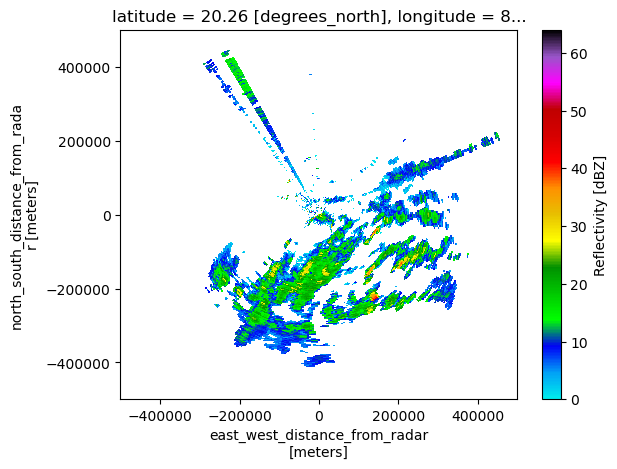

In [11]:
cf_dtree['volume_0']['sweep_0']['DBZ'].plot(x='x', y='y', cmap='NWSRef')

## Important note
You can save this CFRADIAL2 data using xarray and then read it using xarray again

In [12]:
# cf_dtree.to_netcdf("EXAMPLE_NAME_CFRAD2.nc")
# ## and you can read it using xarray
# dtree_cf = xr.open_datatree("EXAMPLE_NAME_CFRAD2.nc")
# dtree_cf

## Gridding

### Setup grid resolution here

In this setup:
- The horizontal domain extends from -200 km to 200 km in both x and y directions.
- The vertical domain extends from 0 km to 10 km in altitude.
- The grid resolution is set to 2000 m (2 km) horizontally and 1000 m (1 km) vertically.
- If finer resolution is required, consider using 500 m for horizontal and 100 m for vertical resolution for higher detail.

In [32]:
x_lims = (-200e3, 200e3)
y_lims = (-200e3, 200e3)
z_lims = (0, 10e3)
h_res = 1000
v_res = 500

In [33]:
tstart = datetime.now()

datasets = []
for vol in cf_dtree.match("volume_*"):
    ds_rx = cf_dtree[vol].radarx.to_grid(
        data_vars=["DBZ"],
        pseudo_cappi=False,
        x_lim=x_lims,
        y_lim=y_lims,
        z_lim=z_lims,
        x_step=h_res,
        y_step=h_res,
        z_step=v_res,
        x_smth=0.2,
        y_smth=0.2,
        z_smth=0.6,
    )
    datasets.append(ds_rx)
    print("Radarx gridding took:", datetime.now() - tstart)
    break
ds = xr.concat(datasets, dim='time')
display(ds)

Radarx gridding took: 0:00:00.430582


<xarray.Dataset> Size: 14MB
Dimensions:    (time: 1, z: 21, y: 401, x: 401)
Coordinates:
  * time       (time) datetime64[ns] 8B 2020-05-19T00:41:11.649074076
  * z          (z) float64 168B 0.0 500.0 1e+03 1.5e+03 ... 9e+03 9.5e+03 1e+04
    lat        (y) float64 3kB 18.44 18.45 18.46 18.47 ... 22.04 22.05 22.05
    lon        (x) float64 3kB 84.76 84.77 84.78 84.79 ... 88.57 88.58 88.59
    latitude   float32 4B 20.26
    longitude  float32 4B 86.65
    altitude   float32 4B 44.0
    crs_wkt    int64 8B 0
  * x          (x) float64 3kB -2e+05 -1.99e+05 -1.98e+05 ... 1.99e+05 2e+05
  * y          (y) float64 3kB -2e+05 -1.99e+05 -1.98e+05 ... 1.99e+05 2e+05
Data variables:
    DBZ        (time, z, y, x) float32 14MB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:      CF/Radial instrument_parameters
    version:          1.3
    title:            
    institution:      India Meteorological Department
    references:       
    source:           
    comment:          im/radarx
    instrument_name:  
    history:          
    radar_name:

In [34]:
## To save the gridded dataset
# ds.to_netcdf("filename_gridded_datetime_radar.nc")

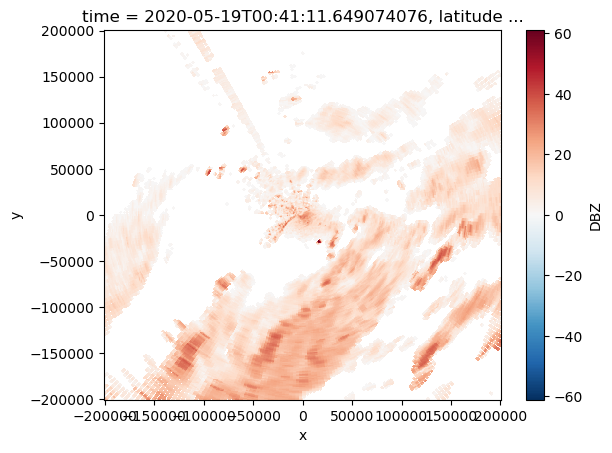

In [35]:
ds['DBZ'].isel(time=0).max("z").plot()

In [36]:
# ds['DBZ'].isel(z=1).sel(x=slice(-150e3, 100e3), y=slice(-200e3, -50e3)).mean(['x', 'y']).plot()

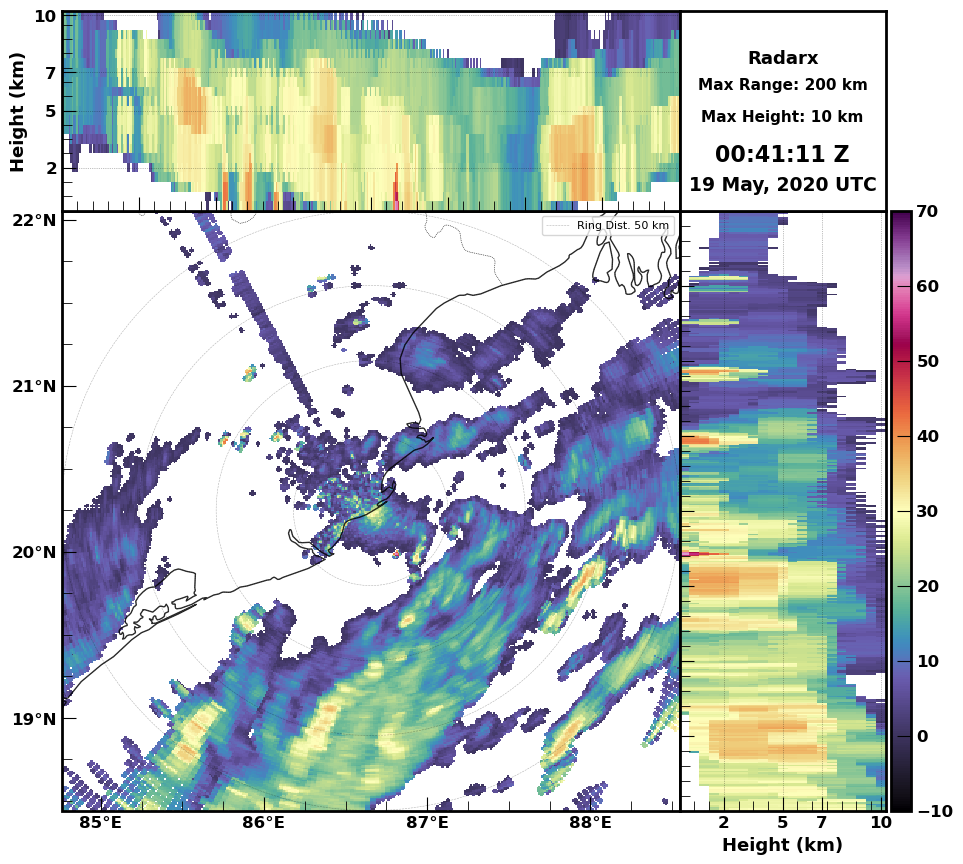

In [37]:
ds.isel(time=0).radarx.plot_max_cappi(
    data_var="DBZ",
    vmin=-10,
    vmax=70,
    range_rings=True,
    add_map=True,
    projection=ccrs.PlateCarree(),
    title="Radarx",
)
plt.show()

In [63]:
# ds.isel(time=20).radarx.plot_max_cappi(
#     data_var="DBZ",
#     vmin=-10,
#     vmax=70,
#     range_rings=True,
#     add_map=True,
#     projection=ccrs.PlateCarree(),
#     title="Radarx",
# )
# plt.show()

## Try gridding with pyart

In [64]:
import pyart
radar = pyart.io.read_cfradial("IMD_OUT/PDP_20200519_004025_cfrad1.nc")

In [65]:
x_lims = (-400e3, 400e3)
y_lims = (-400e3, 400e3)
z_lims = (0, 20e3)
h_res = 1000
v_res = 500

In [66]:
tstart = datetime.now()
# Grid using 11 vertical levels, and 101 horizontal grid cells at a resolution on 1 km
grid = pyart.map.grid_from_radars(
    (radar,),
    grid_shape=(80, 500, 500),
    grid_limits=(
        z_lims,
        y_lims,
        x_lims,
    ),
    fields=["DBZ"],
)

xg = grid.to_xarray()
print("Py-ART gridding took:", datetime.now() - tstart)
display(xg)
del radar

Py-ART gridding took: 0:00:07.448256


<xarray.Dataset> Size: 164MB
Dimensions:                     (time: 1, z: 80, y: 500, x: 500, nradar: 1)
Coordinates: (12/16)
  * time                        (time) object 8B 2020-05-19 00:40:25
  * z                           (z) float64 640B 0.0 253.2 ... 1.975e+04 2e+04
    lat                         (y, x) float64 2MB 16.62 16.62 ... 23.81 23.81
    lon                         (y, x) float64 2MB 82.9 82.92 ... 90.57 90.58
  * y                           (y) float64 4kB -4e+05 -3.984e+05 ... 4e+05
  * x                           (x) float64 4kB -4e+05 -3.984e+05 ... 4e+05
    ...                          ...
    origin_altitude             (time) float32 4B 44.0
    radar_altitude              (nradar) float32 4B 44.0
    radar_latitude              (nradar) float32 4B 20.26
    radar_longitude             (nradar) float32 4B 86.65
    radar_time                  (nradar) int64 8B 0
    radar_name                  (nradar) <U1 4B ''
Dimensions without coordinates: nradar
Data variables:
    DBZ                         (time, z, y, x) float32 80MB nan nan ... nan nan
    ROI                         (time, z, y, x) float32 80MB 9.874e+03 ... 9....
Attributes: (12/16)
    radar_name:       
    nradar:           1
    Conventions:      CF/Radial instrument_parameters
    version:          1.3
    title:            
    institution:      India Meteorological Department
    ...               ...
    history:          
    field_names:      DBT, DBZ, VEL, WIDTH
    volume_number:    0
    platform_type:    fixed
    instrument_type:  radar
    primary_axis:     axis_z

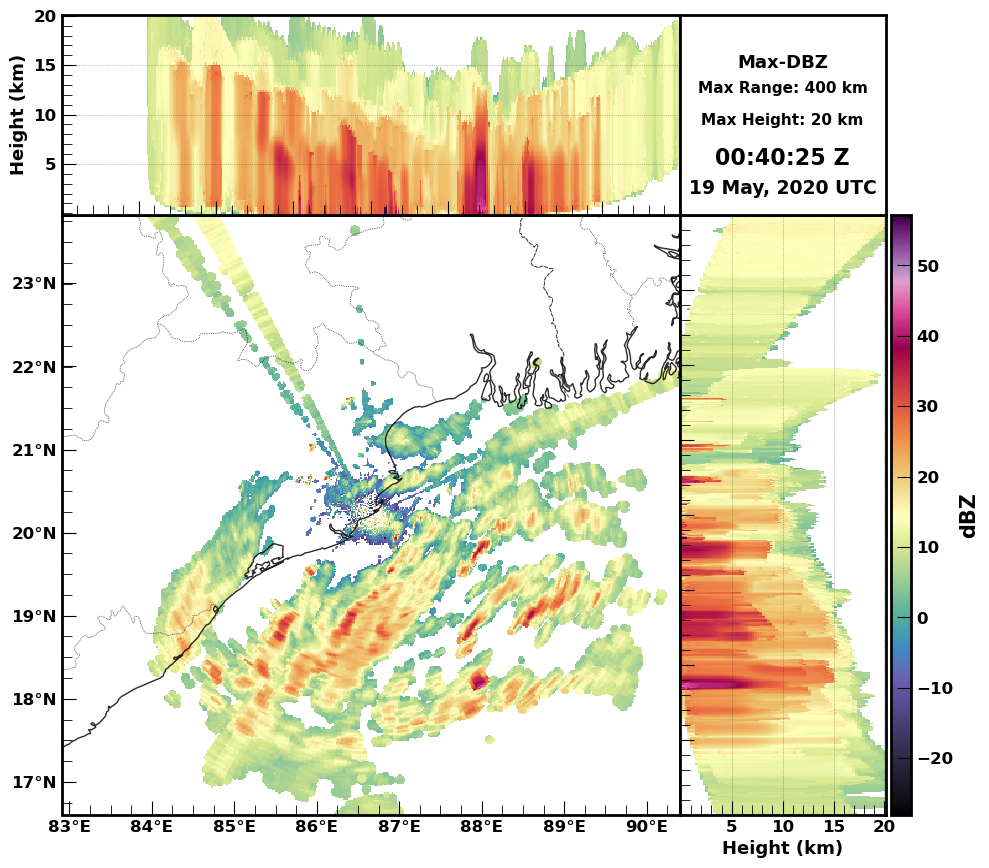

In [67]:
xg.squeeze().radarx.plot_max_cappi("DBZ", )
plt.show()